# Time Series Analysis Project Part 3
## Group G3

**Spring 2024**

*   Paul Miller (Team Lead)
*   Dhyey Joshi
*   Jui Ambikar


Create models and save them as pickle files to be used in a Dash app.

Each education level will have its own model:
- High school
- Some college
- Bachelors degree
- Advanced degree


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

## Import clean data from prior step

In [2]:
file_path = 'data/salary_both_genders_clean.csv'
salaries_df = pd.read_csv(file_path, index_col='year', parse_dates=['year'])
salaries_df.head()

,total_earners,total_earners_salary,no_high_school_earners,no_high_school_salary,high_school_earners,high_school_salary,some_college_earners,some_college_salary,bachelors_earners,bachelors_salary,adv_earners,adv_salary
year,,,,,,,,,,,,
2021-01-01,165282,63050,10886,31050,43930,42850,44019,48070,41873,80380,24572,110600
2020-01-01,164611,72520,10985,35940,42240,39498,45240,44176,41910,73499,24236,104833
2019-01-01,167216,52380,11414,22810,42599,39371,46886,45091,42153,73163,24164,106766
2018-01-01,165179,64340,12058,31870,42882,38936,46887,43053,40231,71155,23118,99919
2017-01-01,163871,74320,12240,36980,42816,38145,47382,41507,39153,67763,22277,98369


### Transformation of data to make it stationary for time series analysis

In prior steps we found that the data was not stationary and needed to be transformed before using as input to models.

- Below we took log transformation to make our time series stationary and plotted a visual for it.
- We found the graph upward trending over time with no seasonality

1. High Shool Salaries

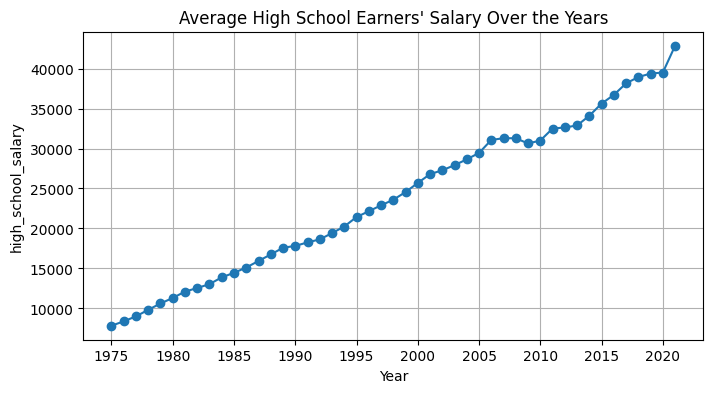

In [4]:
plt.figure(figsize=(8,4))
plt.xlabel("Year")
plt.ylabel("high_school_salary")
plt.plot(salaries_df.index, salaries_df['high_school_salary'], marker='o')
plt.title("Average High School Earners' Salary Over the Years")
plt.grid(True)
plt.show()

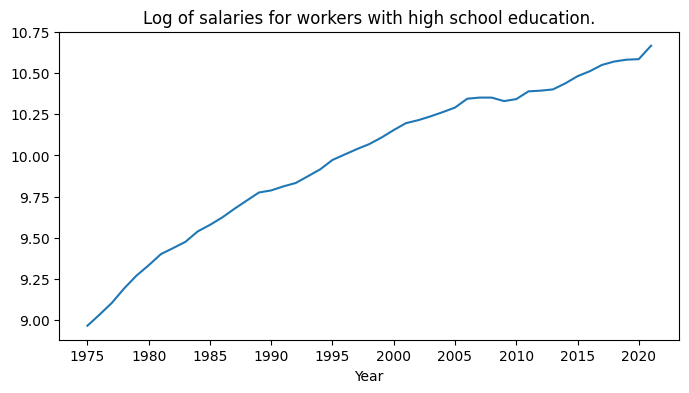

In [5]:
plt.figure(figsize=(8,4))
high_school_data_log=np.log(salaries_df['high_school_salary'])
plt.title("Log of salaries for workers with high school education.")
plt.plot(salaries_df.index, high_school_data_log)
plt.xlabel('Year');

Description of Time series
Calculating Rolling mean and Standard deviation for 5 Years.

In [6]:
rolmean = salaries_df['high_school_salary'].rolling(window=5).mean()
rolstd = salaries_df['high_school_salary'].rolling(window=5).std()

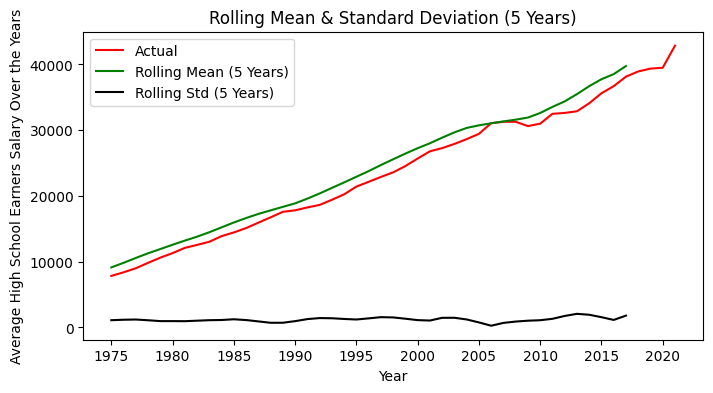

In [8]:
plt.figure(figsize=(8,4))
actual = plt.plot(salaries_df.index, salaries_df['high_school_salary'], color='red', label='Actual')
mean_5 = plt.plot(rolmean, color='green', label='Rolling Mean (5 Years)')
std_5 = plt.plot(rolstd, color='black', label='Rolling Std (5 Years)')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (5 Years)')
plt.xlabel('Year')
plt.ylabel('Average High School Earners Salary Over the Years')
plt.show(block=False)

## Apply differencing

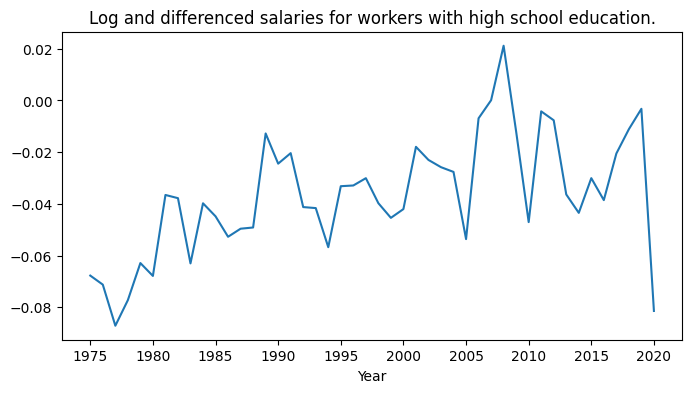

In [13]:
plt.figure(figsize=(8,4))
plt.title("Log and differenced salaries for workers with high school education.")

high_school_log_diff = high_school_data_log-high_school_data_log.shift()
plt.plot(high_school_log_diff)
plt.xlabel('Year');

In [14]:
# Shifting will create one row of Nan. This needs to be dropped before applying adfuller test.
high_school_log_diff.dropna(inplace=True)
high_school_log_diff[0:10]

year
2020-01-01   -0.081456
2019-01-01   -0.003221
2018-01-01   -0.011110
2017-01-01   -0.020525
2016-01-01   -0.038563
2015-01-01   -0.030064
2014-01-01   -0.043499
2013-01-01   -0.036373
2012-01-01   -0.007663
2011-01-01   -0.004207
Name: high_school_salary, dtype: float64

In [15]:
def check_stationarity(input_series):

    rolling_mean=input_series.rolling(window=5).mean()
    rolling_std=input_series.rolling(window=5).std()

    plt.figure(figsize=(8,4))
    orig=plt.plot(input_series, color='black', label='Original')
    mean=plt.plot(rolling_mean, color='green', label='Rolling Mean')
    std=plt.plot(rolling_std, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Dickey-Fuller Test: ')
    test_result=adfuller(input_series, autolag='AIC')
    test_output=pd.Series(test_result[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in test_result[4].items():
        test_output['Critical Value (%s)'%key] = value
    print(test_output)

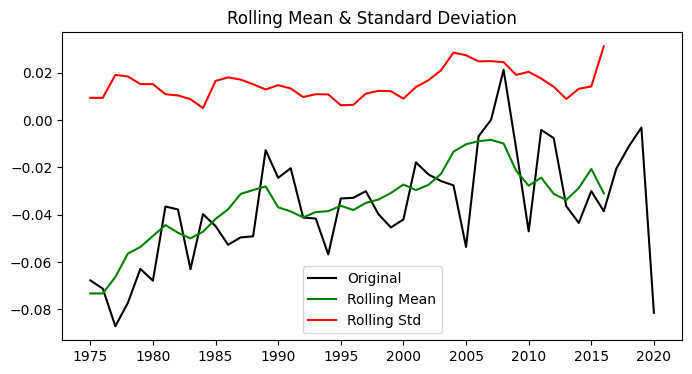

Dickey-Fuller Test: 
Test Statistic                 -3.823836
p-value                         0.002673
Lags Used                       0.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


In [16]:
check_stationarity(high_school_log_diff)

- From ADF, we reject the null hypothesis because p-value is less than 0.05 (significance level)

Decomposition:
Decomposing Time Series into its components: Trend, Seasonality and Residual

In [29]:
highschool_data_log=np.log(salaries_df['high_school_salary'])

In [30]:
highschool_data_log.index = pd.to_datetime(highschool_data_log.index, format='%Y')
highschool_data_log = highschool_data_log.asfreq('AS-JAN')
highschool_data_log.dropna(inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_231356\389295992.py:2: FutureWarning: 'AS-JAN' is deprecated and will be removed in a future version, please use 'YS-JAN' instead.
  highschool_data_log = highschool_data_log.asfreq('AS-JAN')


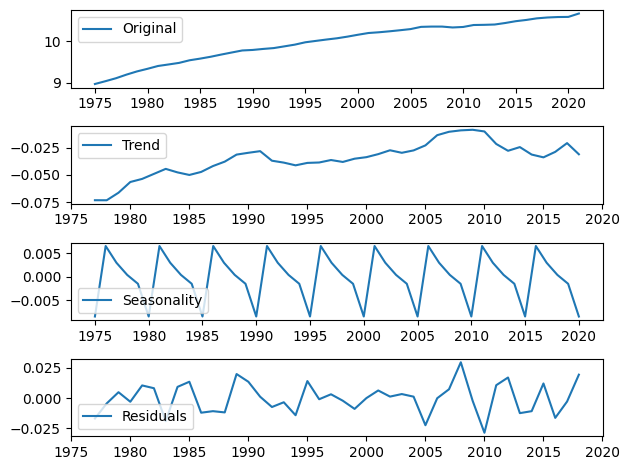

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(high_school_log_diff, model='additive', period=5)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid
residual.dropna(inplace=True)

plt.subplot(411)
plt.plot(highschool_data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [35]:
highschool_log_decompose = residual
highschool_log_decompose.dropna(inplace=True)

## Create models

### AR Model - Auto Regression

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.

plotting AR model


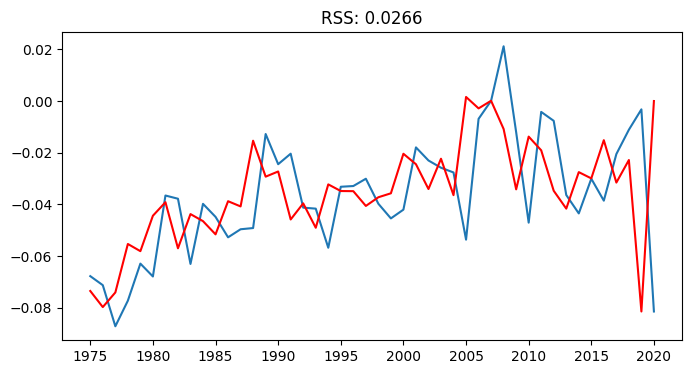

In [17]:
plt.figure(figsize=(8,4))
model=ARIMA(high_school_log_diff, order=(2,1,0))
ar_model=model.fit()
plt.plot(high_school_log_diff)
plt.plot(ar_model.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((ar_model.fittedvalues-high_school_log_diff)**2))
print('plotting AR model')

In [18]:
high_school_ar_forecasted = ar_model.forecast(steps=10)
high_school_ar_forecasted

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


46   -0.073588
47   -0.072731
48   -0.071300
49   -0.072016
50   -0.072205
51   -0.071933
52   -0.071965
53   -0.072035
54   -0.072003
55   -0.071993
Name: predicted_mean, dtype: float64

In [19]:
undifferenced_forecasts = np.cumsum(high_school_ar_forecasted, axis=0)
    
# Undo the log transformation
original_scale_forecasts = np.exp(undifferenced_forecasts)

original_scale_forecasts

46    0.929054
47    0.863882
48    0.804432
49    0.748537
50    0.696394
51    0.648060
52    0.603060
53    0.561147
54    0.522163
55    0.485892
Name: predicted_mean, dtype: float64

In [20]:
# exp only of forecasted values:
np.exp(high_school_ar_forecasted)

46    0.929054
47    0.929851
48    0.931183
49    0.930516
50    0.930340
51    0.930593
52    0.930563
53    0.930498
54    0.930528
55    0.930538
Name: predicted_mean, dtype: float64

MA Model - Moving Average

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.

plotting ARIMA model


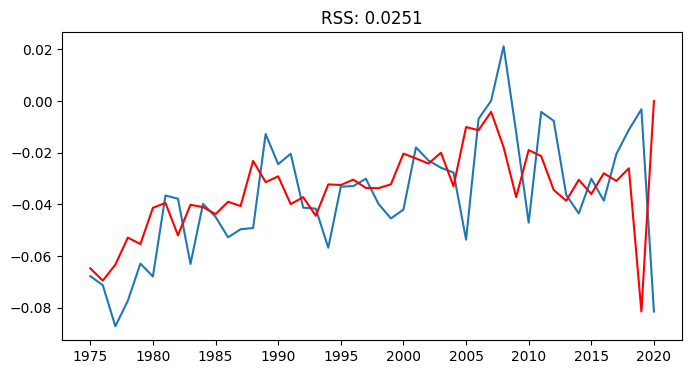

In [21]:
plt.figure(figsize=(8,4))
model=ARIMA(high_school_log_diff, order=(0,1,2))
results=model.fit()
plt.plot(high_school_log_diff)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-high_school_log_diff)**2))
print('plotting ARIMA model')

ARIMA Model

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.

plotting ARIMA model


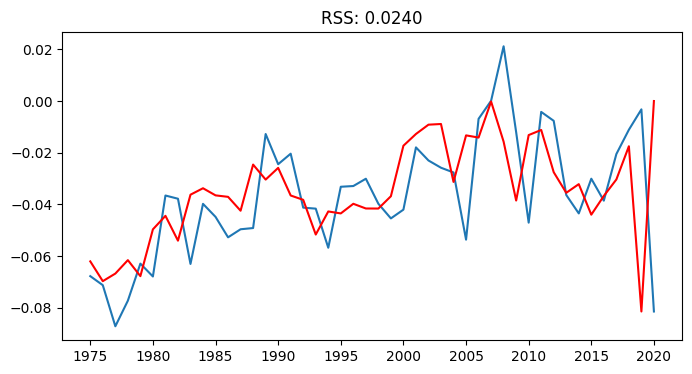

In [22]:
plt.figure(figsize=(8,4))
model=ARIMA(high_school_log_diff, order=(2,1,2))
results=model.fit()
plt.plot(high_school_log_diff)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-high_school_log_diff)**2))
print('plotting ARIMA model')

In [23]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

year
2020-01-01    0.000000
2019-01-01   -0.081456
2018-01-01   -0.017502
2017-01-01   -0.030360
2016-01-01   -0.036731
dtype: float64


In [25]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

year
2020-01-01    0.000000
2019-01-01   -0.081456
2018-01-01   -0.098957
2017-01-01   -0.129317
2016-01-01   -0.166048
dtype: float64


In [27]:
predictions_log=pd.Series(high_school_log_diff.iloc[0], index=high_school_log_diff.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

year
2020-01-01   -0.081456
2019-01-01   -0.162911
2018-01-01   -0.180413
2017-01-01   -0.210773
2016-01-01   -0.247504
dtype: float64

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


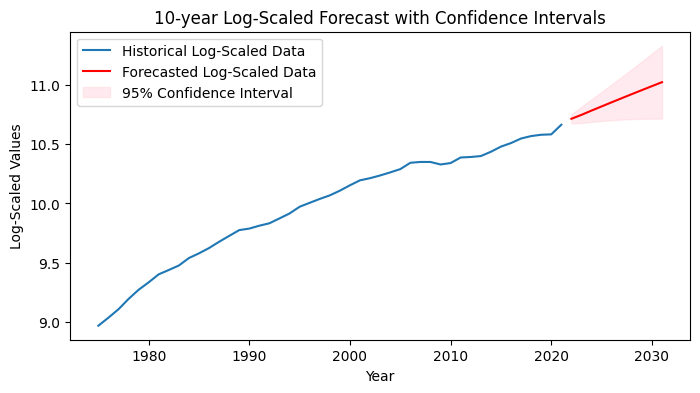

In [31]:
model = ARIMA(highschool_data_log, order=(2, 1, 2))
results = model.fit()

forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=highschool_data_log.index[-1], periods=forecast_steps + 1, freq='YS')[1:]
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(8,4))
plt.plot(highschool_data_log.index,highschool_data_log, label='Historical Log-Scaled Data')
plt.plot(forecast_index, forecast_mean, label='Forecasted Log-Scaled Data', color='red')

plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('10-year Log-Scaled Forecast with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('Log-Scaled Values')
plt.legend(loc='upper left')
plt.show()

In [32]:
import pmdarima as pm

auto_model = pm.auto_arima(highschool_data_log, seasonal=True, m=5,
                           trace=True, error_action='ignore',
                           suppress_warnings=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[5]             : AIC=-216.254, Time=0.50 sec
 ARIMA(0,2,0)(0,0,0)[5]             : AIC=-214.218, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[5]             : AIC=-212.691, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[5]             : AIC=-218.654, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[5]             : AIC=-220.367, Time=0.08 sec
 ARIMA(0,2,1)(1,0,0)[5]             : AIC=-218.807, Time=0.09 sec
 ARIMA(0,2,1)(1,0,1)[5]             : AIC=-218.216, Time=0.18 sec
 ARIMA(1,2,1)(0,0,0)[5]             : AIC=-219.919, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[5]             : AIC=-220.413, Time=0.11 sec
 ARIMA(0,2,2)(1,0,0)[5]             : AIC=-218.931, Time=0.27 sec
 ARIMA(0,2,2)(0,0,1)[5]             : AIC=-218.776, Time=0.16 sec
 ARIMA(0,2,2)(1,0,1)[5]             : AIC=-217.924, Time=0.35 sec
 ARIMA(1,2,2)(0,0,0)[5]             : AIC=-216.394, Time=0.13 sec
 ARIMA(0,2,3)(0,0,0)[5]             : AIC=-218.438, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[5]          

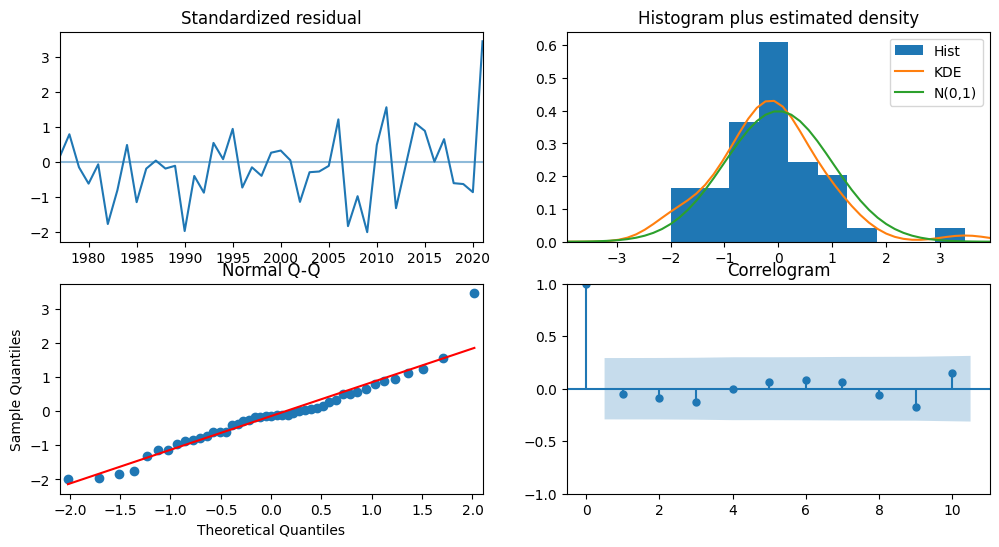

In [33]:
auto_model.plot_diagnostics(figsize=(12, 6))
plt.show()

SARIMAX Model

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.

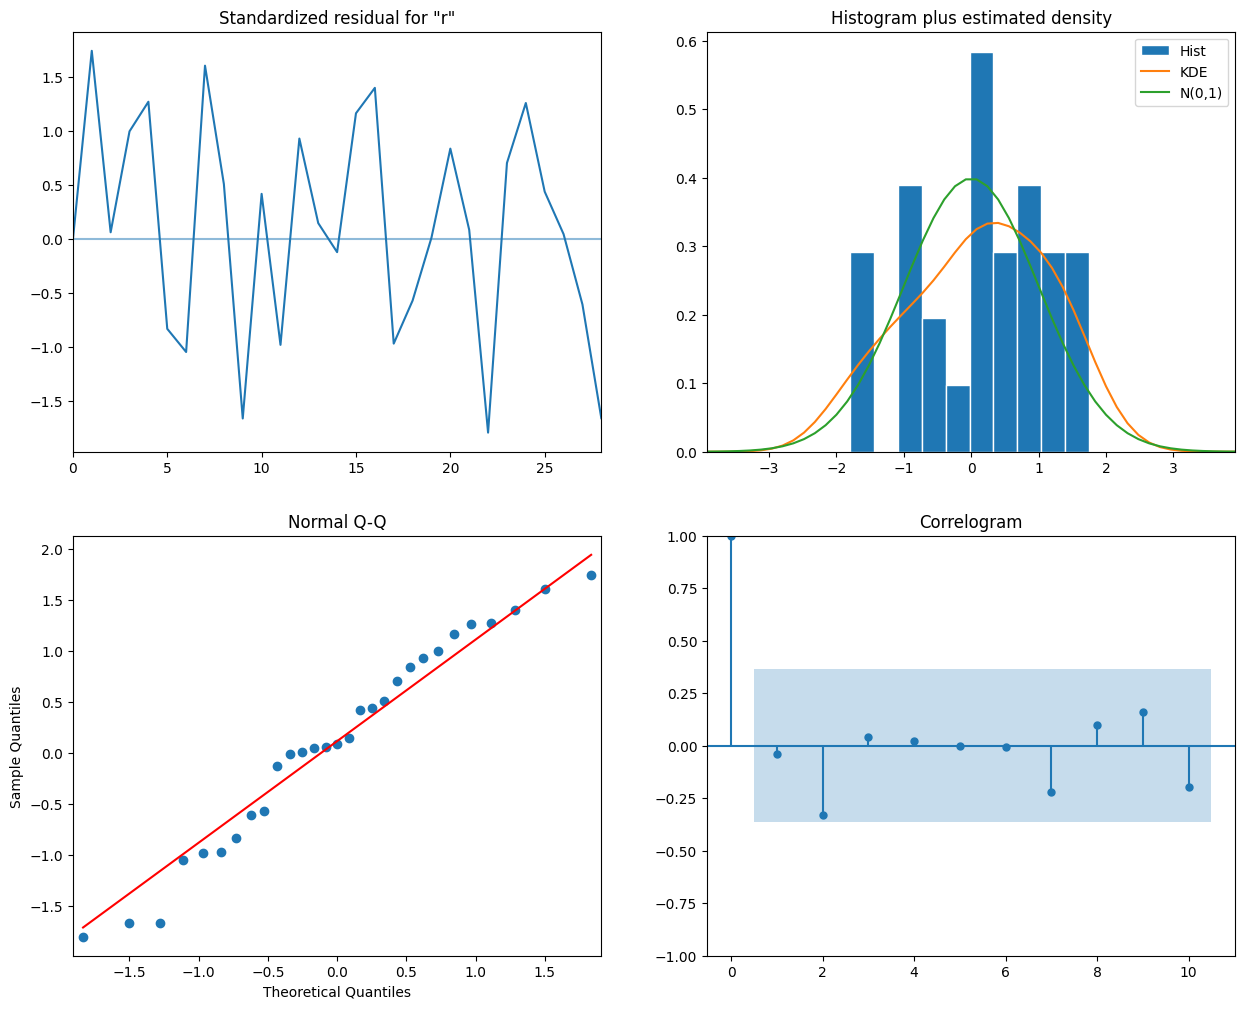

RSS for sarimax model= 0.01653545500364835


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [36]:
sarimax_model = SARIMAX(highschool_log_decompose, order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_results = sarimax_model.fit()
sarimax_results.plot_diagnostics(figsize=(15, 12))
plt.show()
sarimax_forecast = sarimax_results.forecast(steps=12)

residuals = sarimax_results.resid
rss = (residuals ** 2).sum()
print('RSS for sarimax model=', rss)

In [41]:
highschool_log_decompose.index[-1].year

1977

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


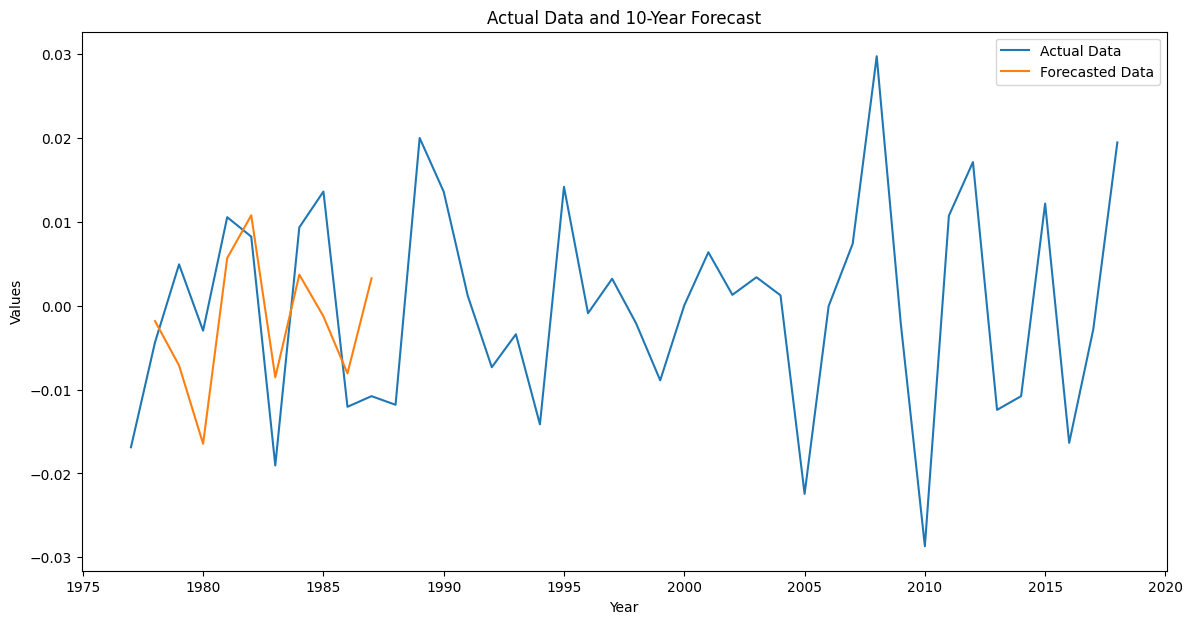

In [40]:
forecast_years = 10
sarimax_forecast = sarimax_results.forecast(steps=forecast_years)

last_year = highschool_log_decompose.index[-1].year
forecast_index = pd.date_range(start=pd.Timestamp(year=last_year + 1, month=1, day=1), periods=forecast_years, freq='YS')
plt.figure(figsize=(14, 7))
plt.plot(highschool_log_decompose.index, highschool_log_decompose, label='Actual Data')
plt.plot(forecast_index, sarimax_forecast, label='Forecasted Data', linestyle='-')
plt.title('Actual Data and 10-Year Forecast')
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend()
plt.show()